## Anomaly Detection

In [1]:
from __future__ import division
# from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
%matplotlib inline

In [2]:
sns.set(color_codes=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
FIGSIZE = (15,10)

### Content
Each row consists of four columns:

 - `date`: `yyyy-mm-dd` (from 2006-07-01 through 2006-09-30)
 - `l_ipn`: local IP (coded as an integer from 0-9)
 - `r_asn`: remote ASN (an integer which identifies the remote ISP)
 - `f`: flows (count of connnections for that day)

Reports of "odd" activity or suspicions about a machine's behavior triggered investigations on the following days (although the machine might have been compromised earlier)


Acknowledgements
This public dataset was found on http://statweb.stanford.edu/~sabatti/data.html

In [5]:
df = pd.read_csv("../dataset/cs448b_ipasn.csv")

# 2. View the data as a table
df.head(10)

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1
5,2006-07-01,0,3320,1
6,2006-07-01,0,3561,13
7,2006-07-01,0,4134,3
8,2006-07-01,0,5617,2
9,2006-07-01,0,6478,1


In [6]:
df['date'].value_counts().shape

(92,)

In [7]:
def reduceData(df):
    cols = df.columns
    m = {}
    d = []
    for row in df.values:
        key = "%s-%s" % (row[0], row[1])
        if key not in m:
            m[key] = [row[0], row[1], "", 0]
            
        m[key][2] += " " +str(row[2])
        m[key][3] += row[3]
        
    for k, v in m.items():
        d.append(v)
        
    return pd.DataFrame(d, columns=cols)

In [8]:
df2 = reduceData(df)

In [9]:
df2.head(10)

,date,l_ipn,r_asn,f
0,2006-07-01,0,701 714 1239 1680 2514 3320 3561 4134 5617 64...,106
1,2006-07-01,1,680 1239 2828 3265 4134 4804 4808 6713 6830 8...,640
2,2006-07-01,2,1312 3561 3659 4323 5617 5661 7018 7132 7377 ...,1677
3,2006-07-01,3,1239 2152 4134 4808 11908 14501 15290 17429 2...,22
4,2006-07-01,4,1239 1668 3356 3561 4323 8282 11908 14501 147...,184
5,2006-07-01,5,2152 3561 4134 4808 8070 8075 11908 13867 143...,44
6,2006-07-01,6,1239 4134 4808 4837 10565 11908 12968 14501 1...,63
7,2006-07-01,7,109 2152 3356 3491 3561 3582 4513 6432 7805 7...,411
8,2006-07-01,8,25 26 109 209 557 786 1103 1653 1668 2152 238...,448
9,2006-07-01,9,102 209 559 701 1239 2152 2911 3356 3561 4267...,1463


In [10]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

In [11]:
df2.index = df2['date']

In [12]:
df2 = df2.drop(['date'], axis=1)

## Analysis of IP 6

Let's look at the no of connections per day

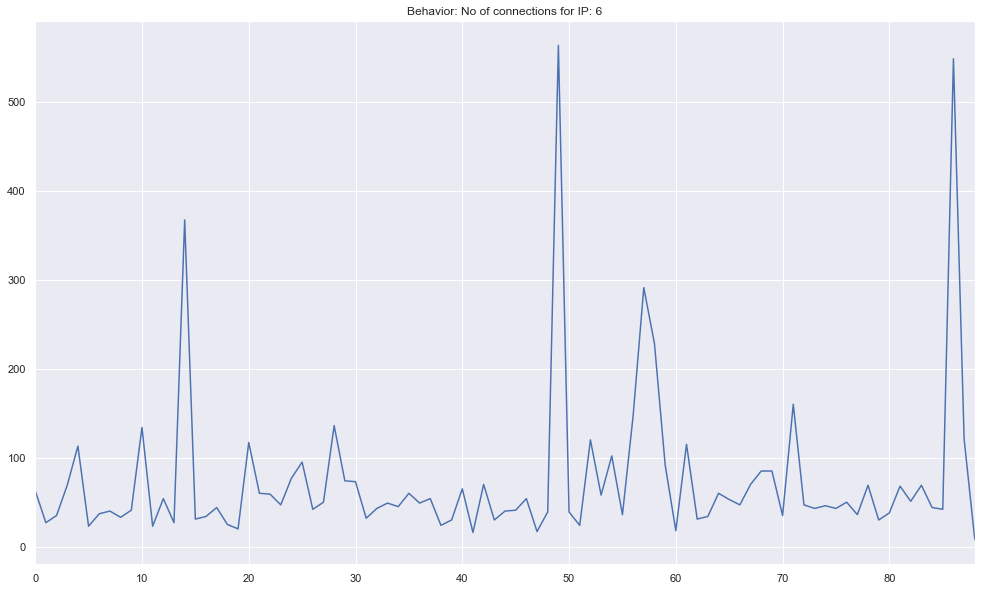

In [13]:
ip = 6
df3 = df2[df2['l_ipn'] == ip]
df3['f_mean'] = df3['f'].mean()

plt.figure(figsize=FIGSIZE)
sns.tsplot(data=df3['f'], ci="sd")
# sns.tsplot(df3['f_mean'], color='red')

plt.title("Behavior: No of connections for IP: %s" % ip)
plt.show()

In [14]:
mvsum = 0
mvcount = 0
mvavg = []

for f in df3['f'].values:
    mvsum += f
    mvcount += 1
    mvavg.append(mvsum / mvcount)
    
df3['mvavg'] = mvavg

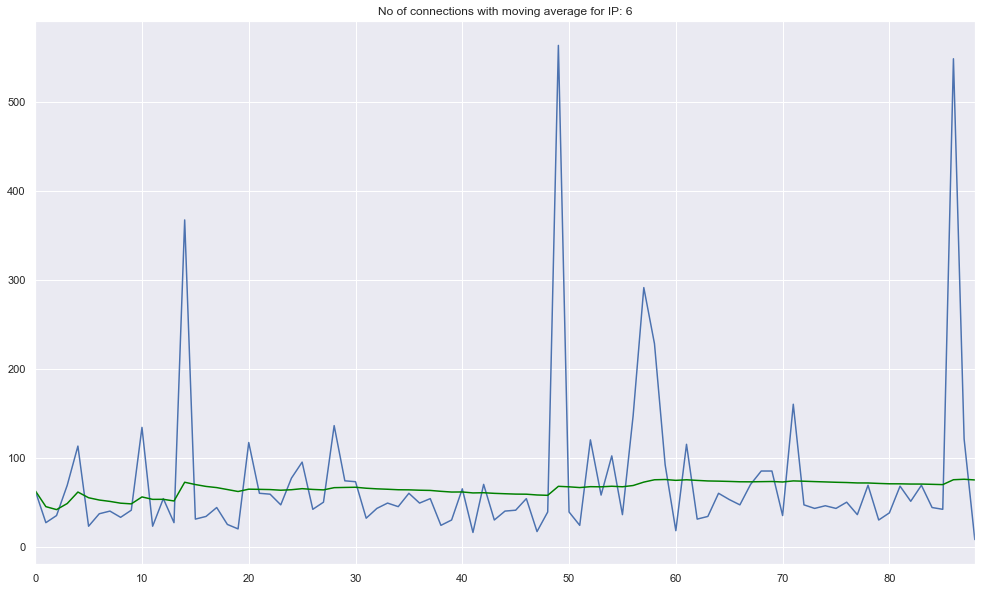

In [15]:
plt.figure(figsize=FIGSIZE)
sns.tsplot(df3['f'])
sns.tsplot(df3['mvavg'], color='green')

plt.title("No of connections with moving average for IP: %s" % ip)
plt.show()

In [16]:
mvavg = []
mvstd = []
mvpost = []
mvnegt = []
W = 2

for i in range(df3.shape[0]):
    _a = df3['f'].values[:i + 1].mean()
    _s = df3['f'].values[:i + 1].std()
    mvavg.append(_a)
    mvstd.append(_s)
    
    mvpost.append(_a + (_s * W))
    mvnegt.append(_a - (_s * W))


df3['mvavg'] = mvavg
df3['mvstd'] = mvstd
df3['mvpost'] = mvpost
df3['mvnegt'] = mvnegt

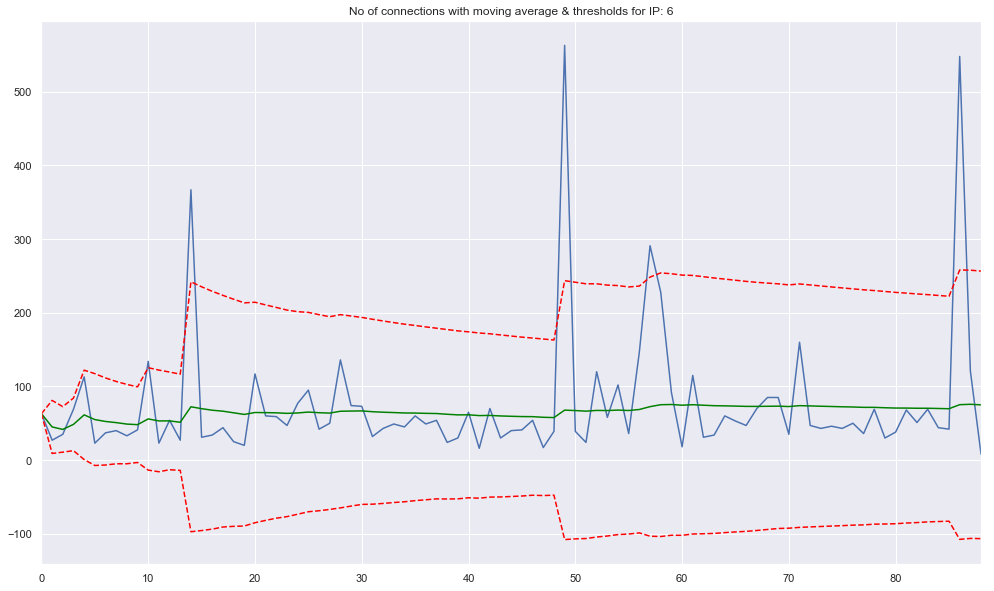

In [17]:
plt.figure(figsize=FIGSIZE)
sns.tsplot(df3['f'])
sns.tsplot(df3['mvavg'], color='green')

sns.tsplot(df3['mvpost'], color='red', linestyle='--')
sns.tsplot(df3['mvnegt'], color='red', linestyle='--')


plt.title("No of connections with moving average & thresholds for IP: %s" % ip)
plt.show()

In [18]:
mvavg = []
mvstd = []
mvpost = []
mvnegt = []
W = 3
S = 10

anomalies = []

points = np.array([0])
for i, f in enumerate(df3['f'].values):
    _a = points.mean()
    _s = points.std()
    _pt = _a + (_s * W)
    _nt = _a - (_s * W)
    
    if i > S and (f > _pt or f < _nt):
        mvavg.append(mvavg[i-1])
        mvstd.append(mvstd[i-1])
        mvpost.append(mvpost[i-1])
        mvnegt.append(mvnegt[i-1])
        
        points = np.append(points, [_a])
        anomalies.append(f)
        continue

    mvavg.append(_a)
    mvstd.append(_s)  
    mvpost.append(_pt)
    mvnegt.append(_nt)
    points = np.append(points, [f])
    anomalies.append(np.float('nan'))


df3['mvavg'] = mvavg
df3['mvstd'] = mvstd
df3['mvpost'] = mvpost
df3['mvnegt'] = mvnegt
df3['anomalies'] = anomalies

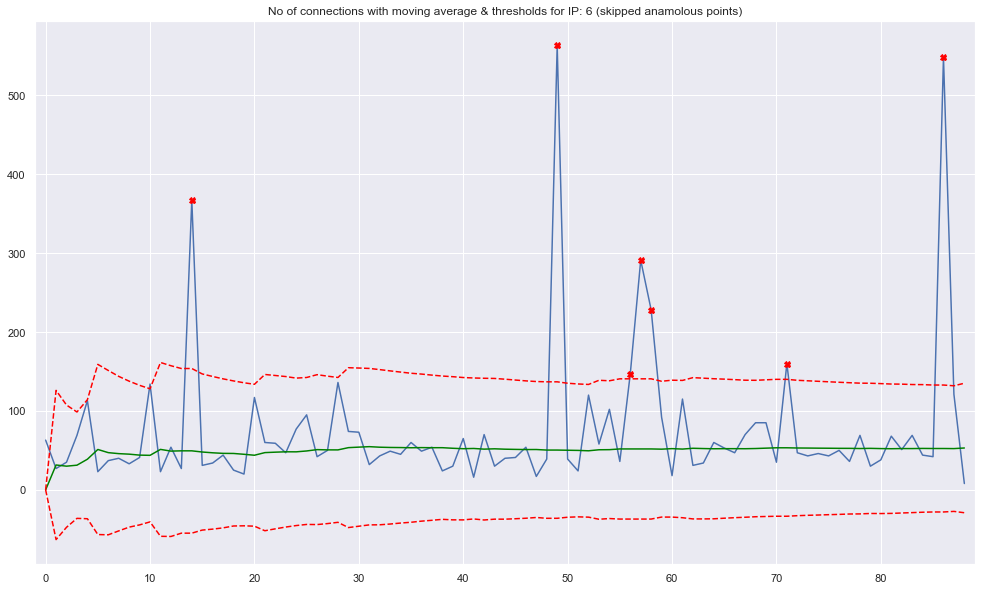

In [19]:
plt.figure(figsize=FIGSIZE)
sns.tsplot(df3['f'])
ax = sns.tsplot(df3['mvavg'], color='green')
# ax.errorbar(df3.index, df3['mvavg'], yerr=df3['mvstd'])#, fmt='-o') #fmt=None to plot bars only

sns.tsplot(df3['mvpost'], color='red', linestyle='--')
sns.tsplot(df3['mvnegt'], color='red', linestyle='--')

ax = sns.tsplot(df3['anomalies'], color='red', marker="x", interpolate=False)
ax.lines[-1].set_marker("X")

plt.title("No of connections with moving average & thresholds for IP: %s (skipped anamolous points)" % ip)
plt.show()

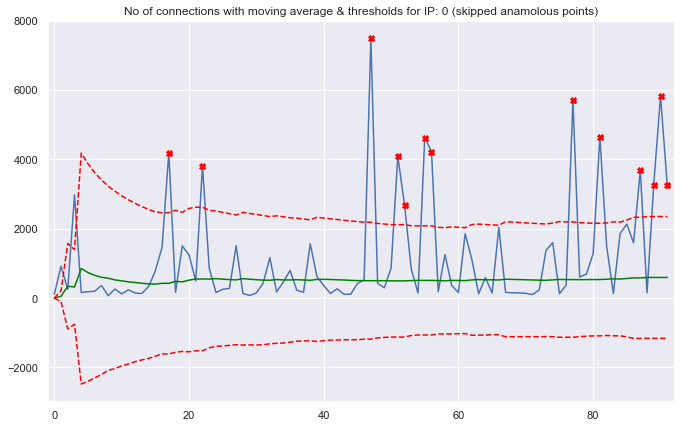

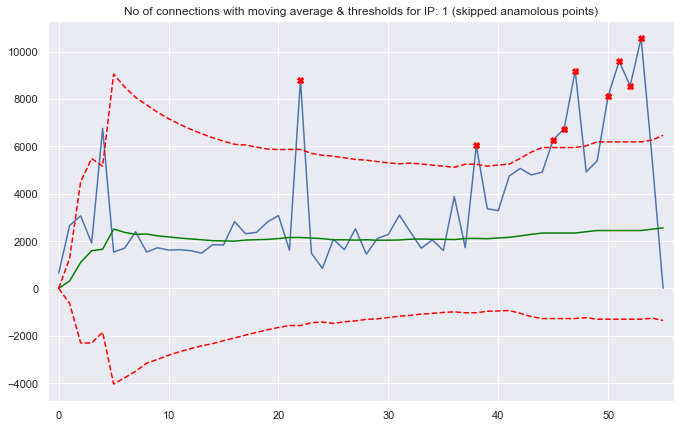

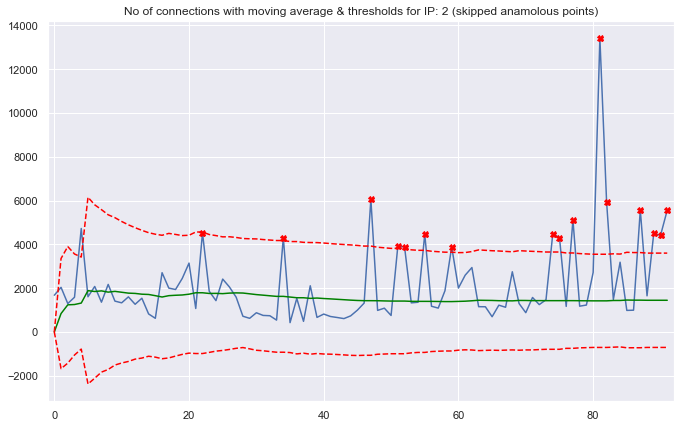

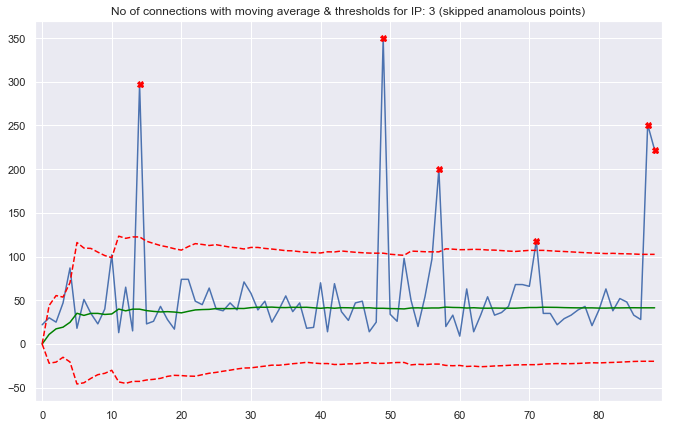

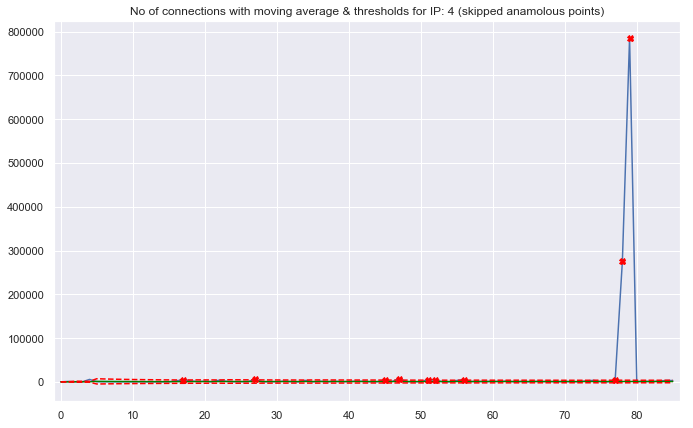

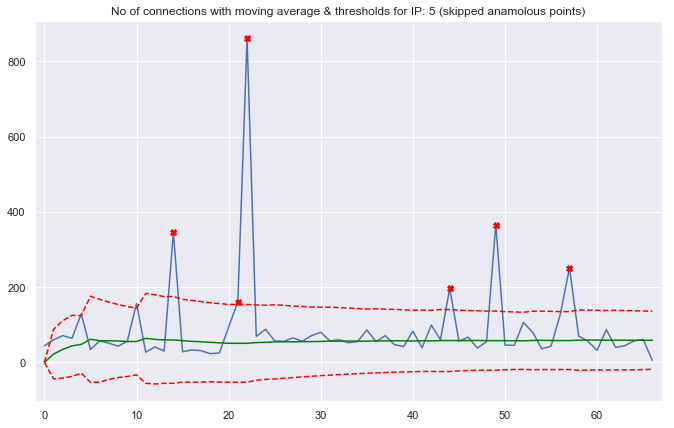

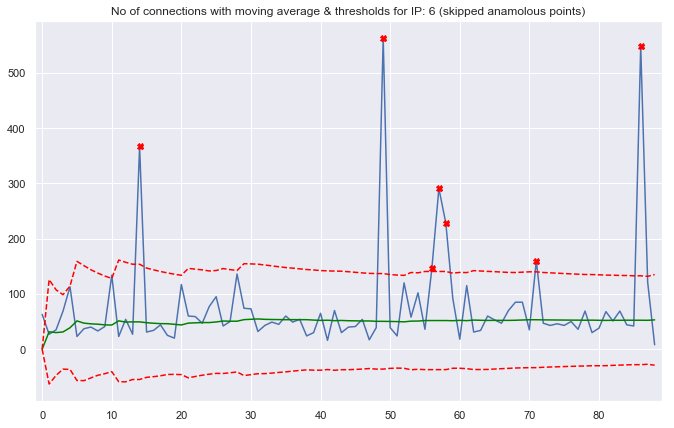

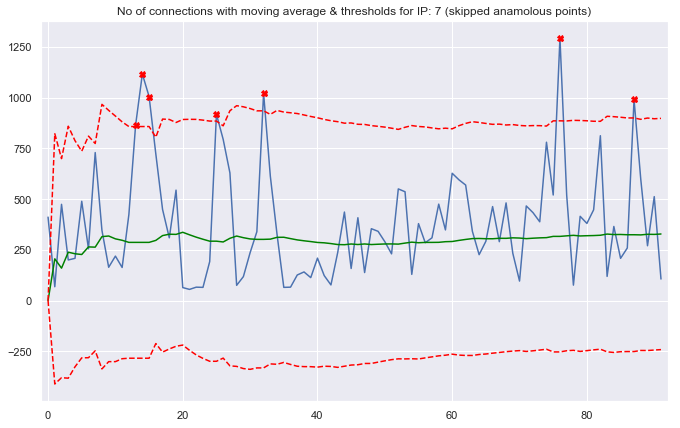

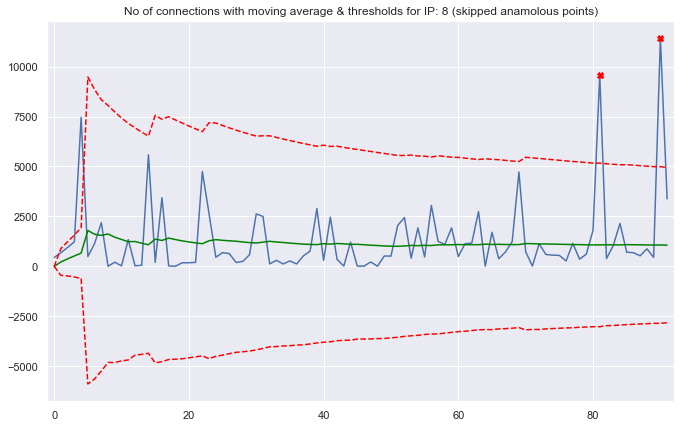

In [20]:
W = 3
S = 10

for ip in range(0, 9):
    df3 = df2[df2['l_ipn'] == ip]
    mvavg = []
    mvstd = []
    mvpost = []
    mvnegt = []


    anomalies = []

    points = np.array([0])
    for i, f in enumerate(df3['f'].values):
        _a = points.mean()
        _s = points.std()
        _pt = _a + (_s * W)
        _nt = _a - (_s * W)

        if i > S and (f > _pt or f < _nt):
            mvavg.append(mvavg[i-1])
            mvstd.append(mvstd[i-1])
            mvpost.append(mvpost[i-1])
            mvnegt.append(mvnegt[i-1])

            points = np.append(points, [_a])
            anomalies.append(f)
            continue

        mvavg.append(_a)
        mvstd.append(_s)  
        mvpost.append(_pt)
        mvnegt.append(_nt)
        points = np.append(points, [f])
        anomalies.append(np.float('nan'))


    df3['mvavg'] = mvavg
    df3['mvstd'] = mvstd
    df3['mvpost'] = mvpost
    df3['mvnegt'] = mvnegt
    df3['anomalies'] = anomalies
    
    plt.figure(figsize=(10,7))
    sns.tsplot(df3['f'])
    sns.tsplot(df3['mvavg'], color='green')

    sns.tsplot(df3['mvpost'], color='red', linestyle='--')
    sns.tsplot(df3['mvnegt'], color='red', linestyle='--')

    ax = sns.tsplot(df3['anomalies'], color='red', marker="x", interpolate=False)
    ax.lines[-1].set_marker("X")

    plt.title("No of connections with moving average & thresholds for IP: %s (skipped anamolous points)" % ip)
    plt.show()

## Bag of word + PCA approach on remote ISP contacted

In [21]:
ip = 6
df3 = df2[df2['l_ipn'] == ip]

df4 = df3[['r_asn','f']]
df4.head(10)

,r_asn,f
date,,
2006-07-01,1239 4134 4808 4837 10565 11908 12968 14501 1...,63
2006-07-02,766 3269 3354 4134 4808 4812 4837 13749 17184,27
2006-07-03,680 3269 4134 4230 4513 4766 4808 4837 7132 9...,35
2006-07-04,4 852 2418 3269 3354 4134 4589 4812 9271 9800...,69
2006-07-05,286 553 4134 4538 4766 4808 4837 9808 10292 1...,113
2006-07-06,4134 4713 4766 4837 8400 11062 12297 18182 18...,23
2006-07-07,1257 4134 4812 4837 6478 7132 8342 9318 17672,37
2006-07-08,3786 4134 4812 4837 5078 5617 14383 25074 27696,40
2006-07-09,3462 4134 4323 4766 4812 4837 8881 9916 14265...,33


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df4['f_white'] = scaler.fit_transform(df4['f'].values.reshape(-1,1))
df4.head(10)

,r_asn,f,f_white
date,,,
2006-07-01,1239 4134 4808 4837 10565 11908 12968 14501 1...,63,-0.132017
2006-07-02,766 3269 3354 4134 4808 4812 4837 13749 17184,27,-0.528441
2006-07-03,680 3269 4134 4230 4513 4766 4808 4837 7132 9...,35,-0.440347
2006-07-04,4 852 2418 3269 3354 4134 4589 4812 9271 9800...,69,-0.065947
2006-07-05,286 553 4134 4538 4766 4808 4837 9808 10292 1...,113,0.418571
2006-07-06,4134 4713 4766 4837 8400 11062 12297 18182 18...,23,-0.572488
2006-07-07,1257 4134 4812 4837 6478 7132 8342 9318 17672,37,-0.418323
2006-07-08,3786 4134 4812 4837 5078 5617 14383 25074 27696,40,-0.385288
2006-07-09,3462 4134 4323 4766 4812 4837 8881 9916 14265...,33,-0.462370


In [23]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(df4['r_asn'].values)
X[0].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [24]:
print ("Shape of the vectors: %d X %d" % (X.shape[0], X.shape[1]))

Shape of the vectors: 89 X 493


In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X.toarray())
X_transformed = pca.transform(X.toarray())
X_transformed[0]

array([0.30995284, 0.14902255])

In [26]:
df4['pca_0'] = X_transformed[:,0]
df4['pca_1'] = X_transformed[:,1]

In [27]:
df4.head(10)

,r_asn,f,f_white,pca_0,pca_1
date,,,,,
2006-07-01,1239 4134 4808 4837 10565 11908 12968 14501 1...,63,-0.132017,0.309953,0.149023
2006-07-02,766 3269 3354 4134 4808 4812 4837 13749 17184,27,-0.528441,-0.546965,0.103675
2006-07-03,680 3269 4134 4230 4513 4766 4808 4837 7132 9...,35,-0.440347,-0.384529,1.038110
2006-07-04,4 852 2418 3269 3354 4134 4589 4812 9271 9800...,69,-0.065947,-0.581860,-0.373514
2006-07-05,286 553 4134 4538 4766 4808 4837 9808 10292 1...,113,0.418571,-0.178208,0.535457
2006-07-06,4134 4713 4766 4837 8400 11062 12297 18182 18...,23,-0.572488,0.104074,0.446454
2006-07-07,1257 4134 4812 4837 6478 7132 8342 9318 17672,37,-0.418323,-0.374137,0.399099
2006-07-08,3786 4134 4812 4837 5078 5617 14383 25074 27696,40,-0.385288,-0.304214,-0.163510
2006-07-09,3462 4134 4323 4766 4812 4837 8881 9916 14265...,33,-0.462370,-0.468904,0.352392


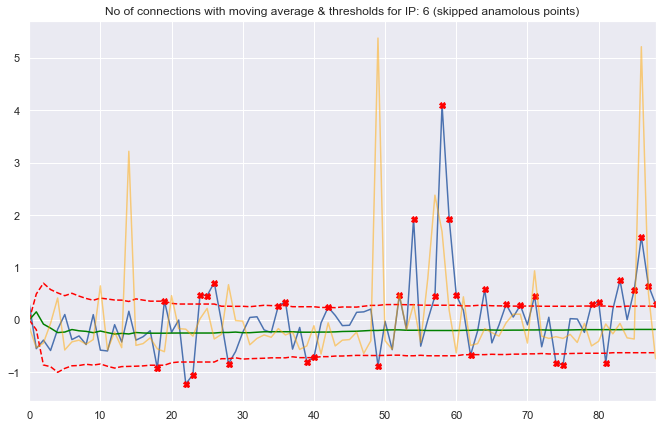

In [28]:
W = 2.2
mvavg = []
mvstd = []
mvpost = []
mvnegt = []
anomalies = []

pca_col = 'pca_0'

points = np.array([0])
for i, f in enumerate(df4[pca_col].values):
    _a = points.mean()
    _s = points.std()
    _pt = _a + (_s * W)
    _nt = _a - (_s * W)

    if i > S and (f > _pt or f < _nt):
        mvavg.append(mvavg[i-1])
        mvstd.append(mvstd[i-1])
        mvpost.append(mvpost[i-1])
        mvnegt.append(mvnegt[i-1])

        points = np.append(points, [_a])
        anomalies.append(f)
        continue

    mvavg.append(_a)
    mvstd.append(_s)  
    mvpost.append(_pt)
    mvnegt.append(_nt)
    points = np.append(points, [f])
    anomalies.append(np.float('nan'))


df4['mvavg'] = mvavg
df4['mvstd'] = mvstd
df4['mvpost'] = mvpost
df4['mvnegt'] = mvnegt
df4['anomalies'] = anomalies

plt.figure(figsize=(10,7))
sns.tsplot(df4[pca_col])
sns.tsplot(df4['mvavg'], color='green')

sns.tsplot(df4['mvpost'], color='red', linestyle='--')
sns.tsplot(df4['mvnegt'], color='red', linestyle='--')

ax = sns.tsplot(df4['anomalies'], color='red', marker="x", interpolate=False)
ax.lines[-1].set_marker("X")

plt.title("No of connections with moving average & thresholds for IP: %s (skipped anamolous points)" % ip)

sns.tsplot(df4['f_white'], color='orange', alpha=0.5)
plt.show()

## Using linkedIn opensource Luminol package

Luminol is a light weight python library for time series data analysis. The two major functionalities it supports are anomaly detection and correlation. It can be used to investigate possible causes of anomaly. You collect time series data and Luminol can:

Given a time series, detect if the data contains any anomaly and gives you back a time window where the anomaly happened in, a time stamp where the anomaly reaches its severity, and a score indicating how severe is the anomaly compare to others in the time series.
Given two time series, help find their correlation coefficient. Since the correlation mechanism allows a shift room, you are able to correlate two peaks that are slightly apart in time.

In [29]:
from luminol.anomaly_detector import AnomalyDetector

In [30]:
ip = 6
df3 = df2[df2['l_ipn'] == ip]
df3['date'] = df3.index
df3.head(10)
ts = df3['f'].values

In [31]:
ts = {}
for i, f in enumerate(df3['f'].values):
    ts[i] = f

my_detector = AnomalyDetector(ts)
score = my_detector.get_all_scores()
anomalies = my_detector.get_anomalies()

In [32]:
df3['anomalies'] = np.float('nan')
anom = df3['anomalies'].values
for a in anomalies:
    tp = a.get_time_window()
    anom[tp[0]] = df3['f'].values[tp[0]]
    
df3['anomalies'] = anom

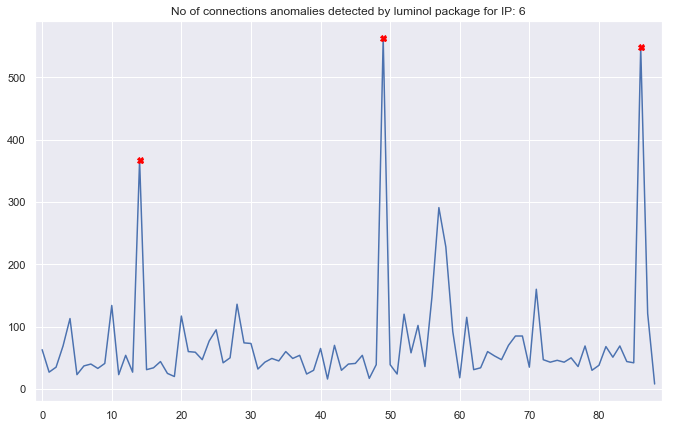

In [33]:
plt.figure(figsize=(10,7))
sns.tsplot(df3['f'])
ax = sns.tsplot(df3['anomalies'], color='red', marker="x", interpolate=False)
ax.lines[-1].set_marker("X")

plt.title("No of connections anomalies detected by luminol package for IP: %s" % ip)
plt.show()

## Using prediction models with error threshold

In [34]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [35]:
ip = 6
df3 = df2[df2['l_ipn'] == ip]
df3.head(10)

,l_ipn,r_asn,f
date,,,
2006-07-01,6,1239 4134 4808 4837 10565 11908 12968 14501 1...,63
2006-07-02,6,766 3269 3354 4134 4808 4812 4837 13749 17184,27
2006-07-03,6,680 3269 4134 4230 4513 4766 4808 4837 7132 9...,35
2006-07-04,6,4 852 2418 3269 3354 4134 4589 4812 9271 9800...,69
2006-07-05,6,286 553 4134 4538 4766 4808 4837 9808 10292 1...,113
2006-07-06,6,4134 4713 4766 4837 8400 11062 12297 18182 18...,23
2006-07-07,6,1257 4134 4812 4837 6478 7132 8342 9318 17672,37
2006-07-08,6,3786 4134 4812 4837 5078 5617 14383 25074 27696,40
2006-07-09,6,3462 4134 4323 4766 4812 4837 8881 9916 14265...,33


In [36]:
df4 = df3['f']
df4.head(20)

date
2006-07-01     63
2006-07-02     27
2006-07-03     35
2006-07-04     69
2006-07-05    113
2006-07-06     23
2006-07-07     37
2006-07-08     40
2006-07-09     33
2006-07-10     41
2006-07-11    134
2006-07-12     23
2006-07-13     54
2006-07-14     27
2006-07-15    367
2006-07-16     31
2006-07-17     34
2006-07-18     44
2006-07-19     25
2006-07-20     20
Name: f, dtype: int64

In [37]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [38]:
dataset = df4.values
dataset = dataset.astype('float32')
print('Dataset length: ', len(dataset))

# normalize the dataset#
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))
print(dataset)

Dataset length:  89
[[0.0990991 ]
 [0.03423423]
 [0.04864865]
 [0.10990991]
 [0.1891892 ]
 [0.02702703]
 [0.05225226]
 [0.05765766]
 [0.04504505]
 [0.05945946]
 [0.22702703]
 [0.02702703]
 [0.08288288]
 [0.03423423]
 [0.64684683]
 [0.04144144]
 [0.04684685]
 [0.06486487]
 [0.03063063]
 [0.02162162]
 [0.1963964 ]
 [0.0936937 ]
 [0.09189189]
 [0.07027027]
 [0.12432432]
 [0.15675676]
 [0.06126127]
 [0.07567568]
 [0.23063064]
 [0.11891893]
 [0.11711712]
 [0.04324324]
 [0.06306306]
 [0.07387388]
 [0.06666667]
 [0.0936937 ]
 [0.07387388]
 [0.08288288]
 [0.02882883]
 [0.03963964]
 [0.10270271]
 [0.01441441]
 [0.11171171]
 [0.03963964]
 [0.05765766]
 [0.05945946]
 [0.08288288]
 [0.01621622]
 [0.05585586]
 [1.        ]
 [0.05585586]
 [0.02882883]
 [0.2018018 ]
 [0.0900901 ]
 [0.16936937]
 [0.05045045]
 [0.25045043]
 [0.5099099 ]
 [0.3963964 ]
 [0.15135135]
 [0.01801802]
 [0.1927928 ]
 [0.04144144]
 [0.04684685]
 [0.0936937 ]
 [0.08108108]
 [0.07027027]
 [0.11171171]
 [0.13873874]
 [0.13873874]


In [39]:
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# print(len(train), len(test))

train = dataset

In [40]:
look_back = 10
trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)
print('trainX:\n{}\n'.format(trainX))
print('trainY:\n{}'.format(trainY))

trainX:
[[0.0990991  0.03423423 0.04864865 0.10990991 0.1891892  0.02702703
  0.05225226 0.05765766 0.04504505 0.05945946]
 [0.03423423 0.04864865 0.10990991 0.1891892  0.02702703 0.05225226
  0.05765766 0.04504505 0.05945946 0.22702703]
 [0.04864865 0.10990991 0.1891892  0.02702703 0.05225226 0.05765766
  0.04504505 0.05945946 0.22702703 0.02702703]
 [0.10990991 0.1891892  0.02702703 0.05225226 0.05765766 0.04504505
  0.05945946 0.22702703 0.02702703 0.08288288]
 [0.1891892  0.02702703 0.05225226 0.05765766 0.04504505 0.05945946
  0.22702703 0.02702703 0.08288288 0.03423423]
 [0.02702703 0.05225226 0.05765766 0.04504505 0.05945946 0.22702703
  0.02702703 0.08288288 0.03423423 0.64684683]
 [0.05225226 0.05765766 0.04504505 0.05945946 0.22702703 0.02702703
  0.08288288 0.03423423 0.64684683 0.04144144]
 [0.05765766 0.04504505 0.05945946 0.22702703 0.02702703 0.08288288
  0.03423423 0.64684683 0.04144144 0.04684685]
 [0.04504505 0.05945946 0.22702703 0.02702703 0.08288288 0.03423423
  0.

In [41]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
print('trainX:\n{}\n'.format(trainX))
# testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX:
[[[0.0990991  0.03423423 0.04864865 0.10990991 0.1891892  0.02702703
   0.05225226 0.05765766 0.04504505 0.05945946]]

 [[0.03423423 0.04864865 0.10990991 0.1891892  0.02702703 0.05225226
   0.05765766 0.04504505 0.05945946 0.22702703]]

 [[0.04864865 0.10990991 0.1891892  0.02702703 0.05225226 0.05765766
   0.04504505 0.05945946 0.22702703 0.02702703]]

 [[0.10990991 0.1891892  0.02702703 0.05225226 0.05765766 0.04504505
   0.05945946 0.22702703 0.02702703 0.08288288]]

 [[0.1891892  0.02702703 0.05225226 0.05765766 0.04504505 0.05945946
   0.22702703 0.02702703 0.08288288 0.03423423]]

 [[0.02702703 0.05225226 0.05765766 0.04504505 0.05945946 0.22702703
   0.02702703 0.08288288 0.03423423 0.64684683]]

 [[0.05225226 0.05765766 0.04504505 0.05945946 0.22702703 0.02702703
   0.08288288 0.03423423 0.64684683 0.04144144]]

 [[0.05765766 0.04504505 0.05945946 0.22702703 0.02702703 0.08288288
   0.03423423 0.64684683 0.04144144 0.04684685]]

 [[0.04504505 0.05945946 0.22702703 0.02

In [42]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0376
Epoch 2/100
 - 0s - loss: 0.0321
Epoch 3/100
 - 0s - loss: 0.0311
Epoch 4/100
 - 0s - loss: 0.0309
Epoch 5/100
 - 0s - loss: 0.0307
Epoch 6/100
 - 0s - loss: 0.0304
Epoch 7/100
 - 0s - loss: 0.0303
Epoch 8/100
 - 0s - loss: 0.0303
Epoch 9/100
 - 0s - loss: 0.0300
Epoch 10/100
 - 0s - loss: 0.0301
Epoch 11/100
 - 0s - loss: 0.0299
Epoch 12/100
 - 0s - loss: 0.0297
Epoch 13/100
 - 0s - loss: 0.0297
Epoch 14/100
 - 0s - loss: 0.0300
Epoch 15/100
 - 0s - loss: 0.0296
Epoch 16/100
 - 0s - loss: 0.0295
Epoch 17/100
 - 0s - loss: 0.0294
Epoch 18/100
 - 0s - loss: 0.0294
Epoch 19/100
 - 0s - loss: 0.0293
Epoch 20/100
 - 0s - loss: 0.0294
Epoch 21/100
 - 0s - loss: 0.0293
Epoch 22/100
 - 0s - loss: 0.0293
Epoch 23/100
 - 0s - loss: 0.0293
Epoch 24/100
 - 0s - loss: 0.0291
Epoch 25/100
 - 0s - loss: 0.0292
Epoch 26/100
 - 0s - loss: 0.0291
Epoch 27/100
 - 0s - loss: 0.0291
Epoch 28/100
 - 0s - loss: 0.0290
Epoch 29/100
 - 0s - loss: 0.0291
Epoch 30/100
 - 0s - lo

In [43]:
# make predictions
trainPredict = model.predict(trainX)
print('trainPredict:\n{}\n'.format(trainPredict[:,0]))
print('trainY:\n{}\n'.format(trainY))
# testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
print('trainPredict:\n{}\n'.format(trainPredict[:,0]))
trainY = scaler.inverse_transform(trainY.reshape(-1,1))
print('trainY:\n{}\n'.format(trainY[:,0]))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

trainPredict:
[ 0.12638849  0.12829508  0.12758741  0.12819722  0.15448801  0.09658734
  0.02293614  0.16936006  0.14086682  0.11528054  0.1168891   0.12725231
  0.20388108  0.1409176   0.19839272  0.13968673  0.09147682  0.12483895
  0.14278683  0.11088674  0.09444985  0.1024      0.13611707  0.13241187
  0.09405634  0.12886995  0.12683156  0.12312058  0.13070655  0.13233425
  0.14949094  0.12861563  0.13551953  0.13576597  0.1387459   0.14702585
  0.13095826  0.14981042  0.13646732  0.14389683  0.10377776 -0.00073683
  0.16287261  0.13129877  0.12740386  0.0654152   0.1887076   0.36133105
  0.2777273   0.12653051  0.06288934  0.11400633  0.06324119  0.02645081
  0.10270698  0.1175783   0.13662268  0.09336489  0.14189407  0.13791257
  0.10516278  0.13831507  0.11453479  0.09477336  0.11882123  0.12179918
  0.13489148  0.09016916  0.12956588  0.14678772  0.11744224  0.15037349
  0.13086018  0.13183673  0.12247921  0.13530162  0.14418012  0.10893375]

trainY:
[0.22702703 0.02702703 0.08

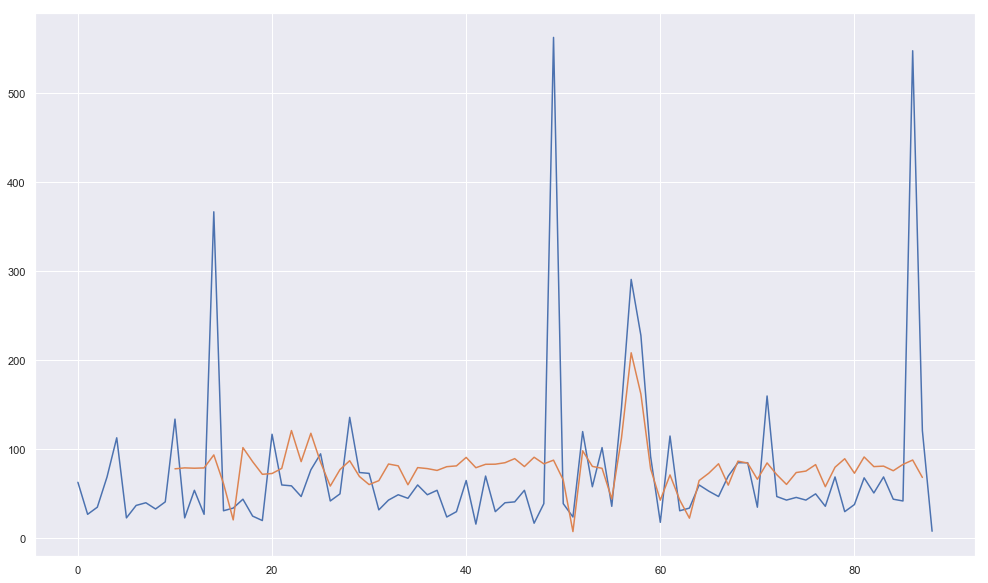

In [45]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions

plt.figure(figsize=(15,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.show()

In [46]:
df5 = pd.DataFrame()
df5['f'] = df4.values
df5['p'] = trainPredictPlot

lb = []
ub = []
an = []

W = 80

for f, p in df5[['f', 'p']].values:
    if np.isnan(np.float(str(p))):
        lb.append(np.float('nan'))
        ub.append(np.float('nan'))
        an.append(np.float('nan'))
        continue
        
    _lb = p - W
    _ub = p + W
    lb.append(_lb)
    ub.append(_ub)
    
    if f < _lb or f > _ub:
        an.append(f)
    else:
        an.append(np.float('nan'))
        
df5['lb'] = lb
df5['ub'] = ub
df5['an'] = an

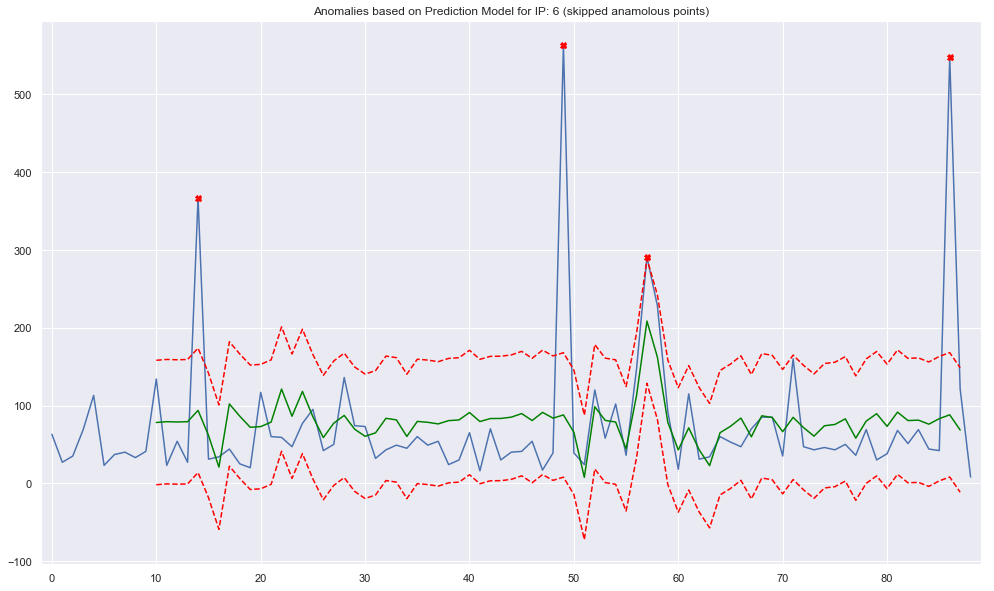

In [47]:
plt.figure(figsize=(15,10))
sns.tsplot(df5['f'])
sns.tsplot(df5['p'], color='green')

sns.tsplot(df5['ub'], color='red', linestyle='--')
sns.tsplot(df5['lb'], color='red', linestyle='--')

ax = sns.tsplot(df5['an'], color='red', marker="x", interpolate=False)
ax.lines[-1].set_marker("X")

plt.title("Anomalies based on Prediction Model for IP: %s (skipped anamolous points)" % ip)

plt.show()